# Lab 12-1 many to one
### word sentiment classification 
* many to one 
* variable input sequence length

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

1.12.0


### Prepairing dataset

In [2]:
# Example data
words = ['good', 'bad', 'worse', 'so good']
y_data = [1,0,0,1]

# Generating a Token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [3]:
# Converting Token to Idx
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [4]:
# Padding 
max_sequence = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')

print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


### Creating graph

In [5]:
# Generating data pipeline 
data = tf.data.Dataset.from_tensor_slices((x_data_len, x_data, y_data))
data = data.shuffle(buffer_size = 4)
data = data.batch(batch_size = 2)
data_iter = data.make_initializable_iterator()
x_mb_len, x_mb, y_mb = data_iter.get_next()
print(x_mb_len, x_mb, y_mb)

Tensor("IteratorGetNext:0", shape=(?,), dtype=int32) Tensor("IteratorGetNext:1", shape=(?, 10), dtype=int32) Tensor("IteratorGetNext:2", shape=(?,), dtype=int32)


In [6]:
# Token representation : one-hot encoding
one_hot_encoding = tf.eye(num_rows = len(idx2char), dtype = tf.float32)
one_hot_encoding = tf.get_variable(name = 'one_hot_encoding',
                                   initializer = one_hot_encoding, trainable = False)
x_mb_batch = tf.nn.embedding_lookup(params = one_hot_encoding, ids = x_mb)

# Generating lstm for "many to one" classification
n_of_classes = 2
hidden_size = 10
lstm_cell = keras.layers.LSTMCell(units = hidden_size)
_, states = tf.nn.dynamic_rnn(cell = lstm_cell, inputs = x_mb_batch, sequence_length = x_mb_len,
                              dtype = tf.float32)

score = keras.layers.Dense(units = n_of_classes)(states[0])
loss = tf.losses.sparse_softmax_cross_entropy(labels = y_mb, logits = score)
prediction = tf.argmax(input = score, axis = -1)

In [7]:
# Creating a training operation
lr = .1
opt = tf.train.AdamOptimizer(learning_rate = lr)
training_op = opt.minimize(loss = loss)

### Training

In [8]:
# Creating a session
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

In [9]:
# Training lstm for "many to one" classification
epochs = 10
tr_loss_hist = []

for epoch in range(epochs):
    
    sess.run(data_iter.initializer)
    avg_tr_loss = 0
    step = 0
    
    try:
        while True:
            _, tr_loss = sess.run([training_op, loss])
            avg_tr_loss += tr_loss
            step += 1
    except:
        avg_tr_loss /= step
        tr_loss_hist.append(avg_tr_loss)
        
    print('epoch : {:3}, loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   1, loss : 0.653
epoch :   2, loss : 0.291
epoch :   3, loss : 0.041
epoch :   4, loss : 0.007
epoch :   5, loss : 0.001
epoch :   6, loss : 0.000
epoch :   7, loss : 0.000
epoch :   8, loss : 0.000
epoch :   9, loss : 0.000
epoch :  10, loss : 0.000


### Checking performance

accuracy : 100.00%


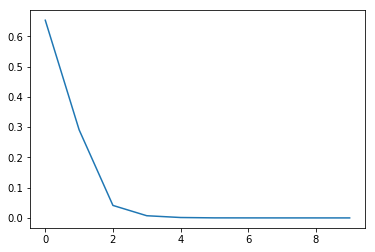

In [10]:
# Checking performance
yhat = sess.run(prediction, feed_dict = {x_mb : x_data, x_mb_len : x_data_len})
print('accuracy : {:.2%}'.format(np.mean(yhat == y_data)))

plt.plot(tr_loss_hist)